Authored by: Patrick Mineault

http://xcorr.net/

Our aim is to fit a maximum entropy model for strings. We could use this to:

  - Model spelling / create a spell-checker
  - Generate fake words / RhymeMaster 3000
  - Do computational linguistics

Maximum entropy models are generative models of exponential form:

$p(x|\theta) =  \frac {1}{Z(\theta)} \exp(\phi(x)^T \theta )$

Where $Z(\theta)$ is a normalization constant:

$Z(\theta) = \int \exp( \phi(x)^T \theta ) dx$

The gradient of the log-likelihood will be:

$\nabla L \equiv \frac{\partial \log p(x|\theta)}{\partial \theta} =  \phi(x)^T \theta - \frac{ \partial \log(Z(\theta)) } { \partial \theta}$

Taking the partial derivative in the second expression, we find:

$\nabla L = \phi(x)^T \theta - \mathbb{E} (\phi(x))$

The expected value on the right hand side is tricky to evaluate. The idea behind contrastive divergence and variants is to compute the expectation in this expression via several independent Markov chains. *Persistent* constrastive divergence means that we won't reset our Markov chains between gradient descent iterations -- although the distribution we need to sample from changes between GD iterations, it changes very slowly. One can prove mathematically that sampling this way converges to the correct ML estimate.

For illustrative purposes, we'll limit our attention to sampling from fixed length strings -- sampling from non-fixed length strings is more annoying, but not necessarily more informative.

# Sampling from fixed-length strings

Let's start by creating a sampler over fixed-length strings. We will use a Metropolis-Hastings (MH) proposal within a Gibbs sampler. What this means:

  - Gibbs: resample one character at a time at each iteration
  - MH: sample a tokeb from a proposal distribution and adjust based on the density function
    - Important life lesson: code the MH sampler on a log scale otherwise numerical problems ensue.
  
Let's do this a dummy density function and verify that we're sampling from the right distribution -- it's very easy to mess up and sample from the wrong distro. Don't do it!

In [0]:
import itertools
import numpy as np
import collections

class FixedLengthGMHMC:
  """Fixed-length string Gibbs-sampling Metropolis-Hastings Markov chain. 
  This class samples from a distribution over string variables of length str_len. 
  It only works on ASCII (or ISO-8859-1).
  It does that by Gibbs sampling, one character at a time. It uses Metropolis 
  Hastings to sample from the marginal distribution of the next character using 
  a proposal distribution log_proposal_dist. The Q function is density_fun. 
  """
  def __init__(self, 
               str_len,
               proposal_dist,  # For individual letter
               log_density_fun):
    self.proposal_dist = proposal_dist
    self.log_density_fun = log_density_fun
    self.str_len = str_len
    
    self.num_accepted = 0
    self.num_tried = 0
    
  def take_first_sample(self):
    # Take a sample from the proposal distribution to start with
    chars = []
    for i in range(self.str_len):
      chars.append(chr(
        np.where(np.random.multinomial(1, self.proposal_dist))[0]))
    
    chars = ''.join(chars)
    self.last_sample = chars
    self.last_sample_log_density = self.log_density_fun(chars)
  
  def sample(self):
    # Take a sample from the conditional distribution of the 
    # str_pos character via MH
    # Pick which character to resample at random
    str_pos = np.int(np.random.rand()*self.str_len)
    
    # Sample a char from the proposal distribution
    new_char = chr(np.where(np.random.multinomial(1, self.proposal_dist))[0])
    
    # Splice it in
    new_sample = (self.last_sample[:str_pos] + 
                  new_char + 
                  self.last_sample[str_pos+1:])
    
    new_sample_log_density = self.log_density_fun(new_sample)
    
    # We're doing everything on the log scale for numerical stability
    alpha1 = np.exp(new_sample_log_density - self.last_sample_log_density)
    
    # Q(x | x') / Q(x' | x)
    old_char = self.last_sample[str_pos]
    alpha2 = (self.proposal_dist[ord(old_char)] / 
              self.proposal_dist[ord(new_char)])
    
    # Acceptance ratio
    alpha = min(alpha1*alpha2, 1.0)
    
    # Draw a binomial sample to decide whether to accept
    accept = np.random.rand() < alpha
    
    if accept:
      self.last_sample = new_sample
      self.last_sample_log_density = new_sample_log_density
      self.num_accepted += 1
    
    self.num_tried += 1

In [0]:
# Test out the sampler on an example density on the letters 
# ABab
def sample_log_density(arr):
  # Is the initial letter an uppercase letter?
  phi0 = (arr[0] == 'A' or 
          arr[0] == 'B')
  
  # Does the second letter follow the first letter? e.g. 'ab'
  phi1 = ord(arr[1]) - ord(arr[0]) == 1
  
  return phi0 * 1.0 + phi1 * 1.5

# Compute the probability of every length 2 string containing the characters
# abAB
charset = 'abAB'
str_len = 2

ps = {}
for the_str in itertools.product(charset, repeat=str_len):
  the_str = the_str[0] + the_str[1]
  ps[the_str] = np.exp(sample_log_density(the_str))
    
# Create a non-uniform proposal distribution, because subtle bugs can lurk 
# in the way we've coded up Q(x|x') / Q(x'|x)
proposal_distro = [(chr(x) in charset) / (1.0 + float(x)) for x in range(128)]
proposal_distro = [x / sum(proposal_distro) for x in proposal_distro]
sampler = FixedLengthGMHMC(str_len, proposal_distro, sample_log_density)
sampler.take_first_sample()

samples = []
# Take some samples
for i in range(10000):
  sampler.sample()
  samples.append(sampler.last_sample)

# Look at empirical distribution of samples
cnt = collections.Counter(samples)

# Concatenate the results
distros = np.array([[y, cnt[x]] for x, y in ps.iteritems()])

# Normalize
distros = distros / distros.sum(0).reshape((1,-1))

print 'String | Exact p(x)*1000 | Sample p(x)*1000'
print '\n'.join(['%s        % 8d         % 8d' % (x, y[0], y[1]) for x, y in 
                 zip(ps.keys(), np.round(distros*1000))])

max_rel_disc = max(abs(.5 * (distros[:,0] - distros[:,1]) / 
                       (distros[:,0] + distros[:,1])))

print 'Max relative discrepancy: %.3f' % max_rel_disc

# relative discrepancy should not be much higher than 6%
assert( max_rel_disc < .06)

print ('Acceptance probability: %.3f' % (sampler.num_accepted / 
  float(sampler.num_tried)))

# That looks good.

String | Exact p(x)*1000 | Sample p(x)*1000
Ba              64               60
BA              64               64
bA              23               22
aa              23               22
bB              23               24
Ab              64               63
AB             285              287
ba              23               22
bb              23               25
Aa              64               59
AA              64               65
BB              64               67
ab             105              106
aA              23               24
Bb              64               65
aB              23               24
Max relative discrepancy: 0.020
Acceptance probability: 0.728


#Persistent contrastive divergence to estimate parameter values 

PCD is an algorithm for maximum likelihood estimation of MaxEnt models. It's essentially gradient descent with a twist: the gradient of a MaxEnt model includes a term corresponding to an expected value wrt. the distribution to be fitted. This value is approximated via parallel Markov chains. The Marjov chains are not reset every gradient descent iteration, hence the *persistence*.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
class FixedLengthPCD:
  """Stores a run of persistent contrastive divergence. Some features of this 
  version of PCD:
    - Uses a sequence of etas to gradient descent for better convergence.
    - Uses RMSProp update rule
  """
  
  def __init__(self, 
               words, 
               feature_fun,
               S_chains = 10):
    """Initializes PCD on a given vocabulary.
    
    Args:
      words: a list of strings, all of the same size
      feature_fun: a function which takes a string and returns an array of 
        features
      S_chains: the number of parallel chains to use for PCD
    """
    self.words = words
    self.feature_fun = feature_fun
    self.S_chains = S_chains
    
    self.init_measurements()
    self.init_params()
    self.init_chains()
  
  def init_measurements(self):
    """Make some measurements on the vocabulary"""
    max_str_len = max(len(w) for w in self.words)
    min_str_len = min(len(w) for w in self.words)
    if min_str_len != max_str_len:
      raise Error('This class only works for fixed-length strings')
      
    # Compute the empirical distribution of tokens
    all_chars = ''.join(self.words)
    proposal_dist,_ = np.histogram(np.array([ord(x) for x in all_chars]),
                                   bins=range(128))
    proposal_dist = proposal_dist / np.float(proposal_dist.sum())  
    
    # Moment matching
    X = np.array([self.feature_fun(w) for w in self.words])
    phi_c = X.mean(0)
    
    self.proposal_dist = proposal_dist
    self.str_len = min_str_len
    self.phi_c = phi_c
    self.n_features = phi_c.size
  
  def log_density_fun(self, word):
    """Returns the log density of a word, i.e. the inner product of the features
    and the parameters"""
    phi = self.feature_fun(word)
    return phi.dot(self.theta)
    
  def get_new_sampler(self):
    """Create a sampler from current set of parameters"""
    s = FixedLengthGMHMC(self.str_len,
                         self.proposal_dist,
                         self.log_density_fun)
    s.take_first_sample()
    return s
    
  def init_chains(self):
    # Initialize MCMC chains
    chains = []
    for i in range(self.S_chains):
      s = self.get_new_sampler()
      chains.append(s)
    self.chains = chains
      
  def init_params(self):
    # Initialize parameters
    sd = .1
    # Alternatively, we could use a crude estimate as an initializer
    self.theta = sd * (np.random.randn(self.n_features) / 
                       np.sqrt(self.n_features))

  def run(self, 
          etas = [0.1], 
          k_steps_per = 5,
          T = 100,
          rms_prop_alpha = .9,
          display_every = 1):
    """Run a number of persistent contrastive divergence iterations.
    
    Args:
      etas: a list of learning rates to use
      k_steps_per: the number of MCMC steps to take per gradient descent 
        iteration
      T: the number of gradient descent iterations
      rms_prop_alpha: the decay rate of RMSProp being used
      
    Returns:
      (thetas, gnorm, likelihoods): sequences of (parameters, 
                      norm of the gradient, likelihoods)
    """
    
    # Fudge factor for RMSProp
    ff = 0.001
    
    thetas = np.zeros((T, self.n_features))
    gnorms = np.zeros((T))
    gnorms_adjusted = np.zeros((T))
    likes = np.zeros((T))
    running_g = np.ones((self.n_features))

    for t in range(T):
      which_eta = (t * len(etas)) / T
      eta = etas[which_eta]

      # Sample for a few steps
      for s in self.chains:
        for m in range(k_steps_per):
          s.sample()

      X_ = np.array([self.feature_fun(s.last_sample) for s in self.chains])
      
      phi_t = X_.mean(0)
      
      # Gradient
      g = self.phi_c - phi_t
      
      # Gradient ascent
      # Use an RMSGrad update for more consistent convergence
      gg = eta* (g / (ff + np.sqrt(running_g)))
      self.theta = self.theta + gg
      thetas[t,:] = self.theta
      running_g = running_g*rms_prop_alpha + g**2
      

      # Monitor convergence
      gnorms[t] = np.sqrt((g**2).sum())
      gnorms_adjusted[t] = np.sqrt((gg**2).sum())
                          
      # Evaluate model likelihood
      like = sum(np.exp(np.array(
        [self.log_density_fun(w) for w in self.words]))) / float(len(self.words))
      likes[t] = like
      
      if t % display_every == 0:      
        print "Iteration %04d, log likelihood = %.8f" % (t, like)

    return thetas, gnorms, gnorms_adjusted, likes   

In [0]:
def sample_feature_fun(arr):
  # Is the initial letter an uppercase letter?
  phi0 = (arr[0] == 'A' or 
          arr[0] == 'B')
  
  # Does the second letter follow the first letter? e.g. 'ab'
  phi1 = ord(arr[1]) - ord(arr[0]) == 1
  
  return np.array([phi0*1.0, phi1*1.0])

# Draw some words
nsamples = 1000
keys = np.random.multinomial(nsamples, distros[:,0])
words = ps.keys()
vocab = list(itertools.chain(*[[words[i]]*k for i, k in enumerate(keys)]))

pcd = FixedLengthPCD(vocab, 
                     sample_feature_fun,
                     S_chains = 100)

convergence = pcd.run(T = 600, 
                      etas = [.1, 0.03, .01],
                      k_steps_per = 1,
                      rms_prop_alpha = 0.9,
                      display_every = 100)

# Plot some indices of convergence
plt.subplot(411)
plt.plot(convergence[0])
plt.title('theta')
plt.subplot(412)
plt.plot(convergence[1])
plt.xlabel('Iteration')
plt.title('||g||')

plt.subplot(413)
plt.plot(convergence[2])
plt.xlabel('Iteration')
plt.title('||g_a||')

plt.subplot(414)
plt.plot(convergence[3])
plt.title('likelihood')

print "Actual parameters"
print np.array([1.0, 1.5])
print "Estimated parameters"
print pcd.theta

samples = []
sampler = pcd.get_new_sampler()
    
sampler.proposal_dist = proposal_distro
for i in range(10000):
  sampler.sample()
  samples.append(sampler.last_sample)

# Look at empirical distribution of samples
cnt = collections.Counter(samples)

# Concatenate the results
distros_ = np.array([[y, cnt[x]] for x, y in ps.iteritems()])

# Normalize
distros_ = distros_ / distros_.sum(0).reshape((1,-1))

print 'String | Exact p(x)*1000 | Sample p(x)*1000'
print '\n'.join(['%s        % 8d         % 8d' % (x, y[0], y[1]) for x, y in 
                 zip(ps.keys(), np.round(distros_*1000))])

max_rel_disc = max(abs(.5 * (distros_[:,0] - distros_[:,1]) / 
                       (distros_[:,0] + distros_[:,1])))

print 'Max relative discrepancy: %.3f' % max_rel_disc

# Run on real data

Let's fit a toy spelling model with features like the number of each letter, whether a vowel is followed by a consonant, etc. for all the 7-letter words in the Wikipedia article on machine learning. We'll add a global feature that determines whether the word is "machine".

In [0]:
words = ['Machine', 'evolved', 'pattern', 'defined', 'machine', 'ability', 'without', 'Machine', 'operate', 'example', 'program', 'Machine', 'closely', 'related', 'focuses', 'through', 'domains', 'Machine', 'Example', 'include', 'optical', 'engines', 'vision.', 'Machine', 'focuses', 'quoted,', 'program', 'respect', 'measure', 'notable', 'machine', 'think?"', 'do?"[9]', 'Machine', 'system.', 'are[10]', 'example', 'desired', 'general', 'leaving', 'towards', 'program', 'dynamic', 'perform', 'certain', 'driving', 'without', 'teacher', 'telling', 'whether', 'Another', 'example', 'playing', 'against', 'Between', 'teacher', 'signal:', 'outputs', 'special', 'problem', 'targets', 'support', 'machine', 'divides', 'learned', 'machine', 'acquire', 'through', 'Another', 'machine', 'desired', 'divided', 'learner', 'produce', 'assigns', 'tackled', 'example', 'classes', 'outputs', 'divided', 'groups.', 'Density', 'mapping', 'related', 'program', 'similar', 'topics.', 'History', 'machine', 'Already', 'problem', 'various', '"neural', 'medical', 'between', 'machine', 'systems', 'plagued', 'systems', 'leading', 'outside', 'proper,', 'pattern', 'science', 'outside', 'Hinton.', 'success', 'Machine', 'started', 'changed', 'nature.', 'shifted', 'methods', 'Machine', 'methods', 'overlap', 'roughly', 'Machine', 'focuses', 'learned', 'focuses', 'unknown', 'overlap', 'machine', 'machine', 'employs', 'methods', 'improve', 'learner', 'between', 'machine', 'usually', 'respect', 'ability', 'unknown', 'respect', 'typical', 'methods', 'Machine', 'express', 'between', 'trained', 'problem', 'trained', 'predict', 'between', 'machine', 'Machine', 'closely', 'related', 'fields.', 'Michael', 'Jordan,', 'machine', 'science', 'overall', 'Breiman', 'wherein', 'machine', 'forest.', 'adopted', 'methods', 'machine', 'leading', 'learner', 'context', 'ability', 'machine', 'perform', 'unknown', 'learner', 'general', 'enables', 'produce', 'machine', 'science', 'theory.', 'Because', 'usually', 'common.', 'trained', 'unknown', 'complex', 'complex', 'minimum', 'bounds,', 'theory,', 'results', 'certain', 'learned', 'results', 'certain', 'classes', 'learned', 'between', 'machine', 'machine', 'between', 'network', 'network', 'usually', '"neural', 'aspects', 'usually', 'complex', 'between', 'capture', 'unknown', 'between', 'uniform', 'logical', 'program', 'entails', 'related', 'Support', 'Support', 'Support', 'related', 'methods', 'whether', 'example', 'Cluster', 'Cluster', 'subsets', '(called', 'cluster', 'similar', 'defined', 'example', 'between', 'members', 'between', 'methods', 'density', 'network', 'network', 'acyclic', 'acyclic', 'network', 'between', 'network', 'compute', 'various', 'perform', 'actions', 'reward.', 'attempt', 'actions', 'states.', 'differs', 'problem', 'correct', 'actions', 'Several', 'include', 'cluster', 'attempt', 'useful,', 'unknown', 'attempt', 'learned', 'attempt', 'learned', 'zeros).', 'without', 'defined', 'machine', 'factors', 'explain', 'machine', 'similar', 'similar', 'predict', 'objects', 'method,', 'assumed', 'sparse.', 'matrix,', 'solving', 'sparse.', 'assumed', 'freedom', 'NP-hard', 'popular', 'applied', 'several', 'problem', 'classes', 'belongs', 'Suppose', 'already', 'applied', 'Genetic', 'Genetic', 'genetic', 'process', 'natural', 'methods', 'finding', 'machine', 'genetic', 'machine', 'improve', 'genetic', 'machine', 'finance', 'vision,', 'Machine', 'Medical', 'Natural', 'systems', 'engines', 'opinion', 'mining)', 'pattern', 'Finance', 'company', 'Netflix', 'program', 'predict', 'improve', 'Shortly', 'Netflix', 'ratings', 'viewing', 'changed', 'Journal', 'machine', 'predict', 'article', 'machine', 'applied', 'History', 'between']

Iteration 0000, log likelihood = 1.20084818
Iteration 0100, log likelihood = 12494850.38926714
Iteration 0200, log likelihood = 2762440748.43619156
Iteration 0300, log likelihood = 50845303416.27217102
Iteration 0400, log likelihood = 2190501833230.38696289
Iteration 0500, log likelihood = 4276988176134.80468750
Iteration 0600, log likelihood = 11247602689282.73437500
Iteration 0700, log likelihood = 25981700574598.57031250
Iteration 0800, log likelihood = 24467063671332.46093750
Iteration 0900, log likelihood = 32817339298285.48437500
Estimated parameters
[  3.35791760e+00   1.83633295e-02   1.95713117e+00  -1.02220839e+00
   1.99813306e+00   6.06049274e-01   2.19943471e+00   2.00876385e+00
   2.60486341e+00   4.57186511e-01   1.10098610e+00   1.58116821e+00
   1.86626637e+00  -2.49000326e+00   1.21867005e-01   2.11907471e+00
   1.95922081e+00   2.51286906e+00   1.52986826e+00   1.74849790e+00
  -1.62980114e+00   2.44229185e+00   2.21451871e+00   2.44444045e+00
   1.04837968e+00   2.8

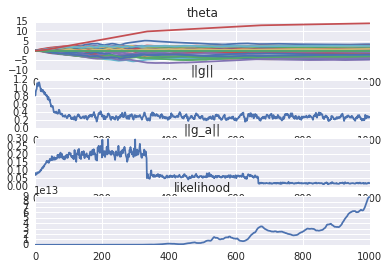

In [0]:
def compute_features(word):
  
  phis = []
  # Check whether the first letter is uppercase
  phis.append(1*(word[0] >= 'A' and word[0] <= 'Z'))
  
  # Check whether the other letters are uppercase
  phis.append(sum(l >= ord('A') and l <= ord('Z') for l in word[1:]))
  
  # Check whether vowels are followed by consonants
  vowels = 'aeiou'
  
  letters = ('abcdefghijklmnopqrstuvwxyz'
             'ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    
  phis.append(sum(x in letters and x not in vowels and y in vowels for x,y in 
                  zip(word[:-1], word[1:])))

  # Check the number of symbols
  phis.append(sum(x not in letters for x in word))
  
  # The number of each letter 
  phis += [sum(x == y for x in word) for y in letters]
  
  # And whether the word is machine (to add a global feature)
  phis.append(word == 'machine' or word == 'Machine')
  
  return np.array(phis)

# Draw some words
pcd = FixedLengthPCD(words, 
                     compute_features,
                     S_chains = 100)

convergence = pcd.run(T = 1000, 
                      etas = [.1, 0.03, .01],
                      k_steps_per = 1,
                      rms_prop_alpha = 0.9,
                      display_every = 100)

# Plot some indices of convergence
plt.subplot(411)
plt.plot(convergence[0])
plt.title('theta')
plt.subplot(412)
plt.plot(convergence[1])
plt.xlabel('Iteration')
plt.title('||g||')

plt.subplot(413)
plt.plot(convergence[2])
plt.xlabel('Iteration')
plt.title('||g_a||')

plt.subplot(414)
plt.plot(convergence[3])
plt.title('likelihood')

print "Estimated parameters"
print pcd.theta


In [0]:
samples = []
sampler = pcd.get_new_sampler()
    
for i in range(10000):
  sampler.sample()
  samples.append(sampler.last_sample)

print "Some samples:"
samples[::100]

Some samples:


['gotrobt',
 'ntrrirs',
 'aldarac',
 'rntHcbr',
 'sumenCs',
 'umorego',
 'elihgah',
 'catccin',
 'rirucab',
 'gnilvlm',
 'hodeehb',
 'osupiag',
 'tedralh',
 'rorwemr',
 'Mhmnsru',
 'ricdpin',
 'lereeno',
 'N,mbndo',
 'rNanivu',
 'nitpitn',
 'tarmNau',
 'ensgfen',
 'ramsake',
 'Stpanri',
 'rrsenor',
 'cntaett',
 'Abenecd',
 'papiloc',
 'fuiyeob',
 'pfrmnet',
 'tresehi',
 'ealutsr',
 'naeqsnn',
 'eeemcnn',
 'titrole',
 'Sedulam',
 'irorige',
 'lccsapi',
 'fbisere',
 'dlnlexa',
 'gedwena',
 'holttad',
 'scoinos',
 'stnyepl',
 '(anisdu',
 'bbneye(',
 'uohsgcn',
 'mineftl',
 'yaintso',
 'SenatAt',
 'hlatunl',
 'ylica:i',
 ')diliyi',
 'ricaene',
 'egeceme',
 'ceciesa',
 'nudrtch',
 'lchinhl',
 'lradiar',
 'nelsmef',
 '[legate',
 'yinoroe',
 '0ieceti',
 'nexatis',
 'damita,',
 'legnmae',
 'nlihhrb',
 'mucrnin',
 'cmnpena',
 'wetdebe',
 'celcekm',
 'dertime',
 'pirlhif',
 'cilhini',
 'ghtrcir',
 'Helrons',
 'gritmda',
 'thdemer',
 'busathi',
 'epemcei',
 'ierokrs',
 'Ghmipac',
 'sairoau',
 'xf

In [0]:
print 'Most likely word'
print max([(sampler.log_density_fun(x),x) for x in words])
print 'log-likelihod of machine versus machina:'
print (sampler.log_density_fun('machine'),
       sampler.log_density_fun('machina'))
print 'Number of machine samples out of 10000:'
print(sum(x == 'machine' for x in samples))
print "Weight for word 'machine'"
print pcd.theta[-1]

Most likely word
(34.704358830698958, 'machine')
log-likelihod of machine versus machina:
(34.704358830698958, 19.98661878108004)
Number of machine samples out of 10000:
0
Weight for word 'machine'
14.1110096977


What's interesting is that the model has learned that machine is by far the most likely word -- it's given a huge weight of 14 to the corresponding feature -- but the sampler didn't find it once in 10k samples! If the chain ever stumbled onto the word machine, it would have a 1 in exp(14) chance of getting unstuck! The weight for the word machine is much too large, and this is because the chains don't mix well enough to find such a global feature. We have to be careful about blindly implementing global features then!